In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
model_name = "Jzuluaga/bert-base-speaker-role-atc-en-uwb-atcc"
model_display_name = "Juan's Model"

label2id = {"atc": 0, "pilot": 1}
id2label = {v: k for k, v in label2id.items()}

dataset = load_dataset("USERNAME/DATASET_TEST_SET")
dataset = dataset.map(lambda x: {"label": label2id[x["class"]]})
test_dataset = dataset["test"]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [3]:
batch_size = 64
all_preds, all_labels = [], []

pbar = tqdm(total=len(test_dataset), desc=f"Evaluating with {model_display_name}")
for start in range(0, len(test_dataset), batch_size):
    batch = test_dataset.select(range(start, min(start + batch_size, len(test_dataset))))
    enc = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt", max_length=256)
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    labels = torch.tensor(batch["label"]).to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    pbar.update(len(batch))

pbar.close()

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary", zero_division=0)
accuracy = accuracy_score(all_labels, all_preds)

print(f"\n{model_display_name} - Test Set Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Evaluating with Juan's Model: 100%|██████████| 2652/2652 [00:01<00:00, 1582.17it/s]


Juan's Model - Test Set Evaluation Metrics:
Accuracy : 0.8903
Precision: 0.8710
Recall   : 0.9163
F1 Score : 0.8931


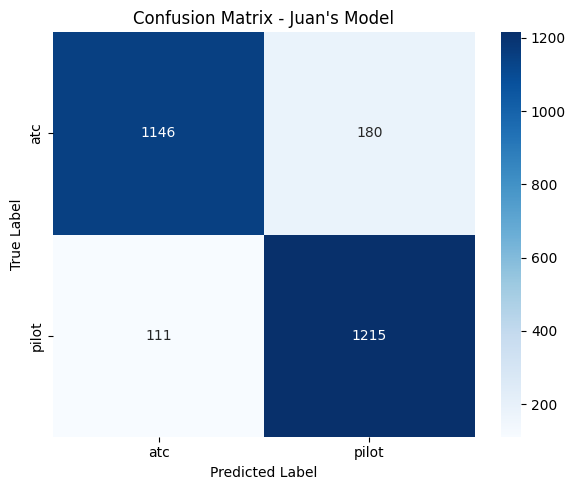

In [5]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["atc", "pilot"], yticklabels=["atc", "pilot"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {model_display_name}")
plt.tight_layout()
plt.show()